In [1]:
import random
from pathlib import Path
from typing import Callable, List, Optional, Union, Sequence
import matplotlib
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from torch import nn, optim
from pytorch_lightning.metrics.functional import accuracy
from sklearn.metrics import confusion_matrix
from sunpy.net.vso import VSOQueryResponseTable
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

from solarnet.utils.physics import id_to_class, flux_to_binary_class
from solarnet.utils.plots import plot_confusion_matrix, plot_image_grid

import boto3
from tqdm import tqdm
from solarnet.utils.yaml import load_yaml

import pl_bolts as B
# from pl_bolts.models.self_supervised import SimCLR
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.models.self_supervised.simclr.transforms import (
    SimCLREvalDataTransform, SimCLRTrainDataTransform)

import math
import torchvision.transforms.functional as transforms_functional
from solarnet.data.dataset_utils import BaseDataset
from solarnet.data.transforms import SDOSimCLRDataTransform, sdo_dataset_normalize
from solarnet.data.sdo_dataset import SDODatasetDataModule
from solarnet.data.sdo_benchmark import SDOBenchmarkDataModule
from pl_bolts.transforms.self_supervised import Patchify, RandomTranslateWithReflect
from solarnet.utils.target import flux_to_class_builder
from solarnet.models.simclr import SimCLR
from solarnet.callbacks.ssl_online_evaluator import SSLOnlineEvaluator

from typing import Optional, Sequence, Tuple, Union

from solarnet.models.ssl_finetuner import SSLFineTuner
from solarnet.models.backbone import get_backbone
from solarnet.models.image_classification import ImageClassification


In [9]:
channel = 171
base_resize = 512
resize = 128
classes_bin = [
    {"Quiet": "< 1e-6"},
    {">=C": ">= 1e-6"},
]

transform = SDOSimCLRDataTransform(
    128,
    do_online_transform=True,
    transform_before=transforms.CenterCrop((base_resize // 2, base_resize - base_resize // 8)),
    transform_after=sdo_dataset_normalize(channel),
)

dm = SDODatasetDataModule(
    Path("../data/sdo-dataset-ssl-171-1h-1"),
    transform=transform,
    target_transform=flux_to_class_builder(classes_bin),
    batch_size=768,
    num_workers=20,
)
dm.setup()

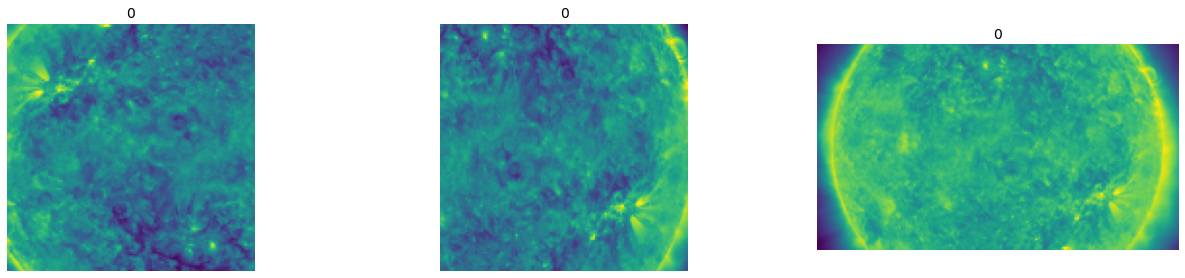

In [11]:
sample_id = 0
img_data_id = 0

samples = [i[0] for i in dm.dataset_train[sample_id][img_data_id]]

plot_image_grid(samples, [0,0,0], columns=3, height=10)

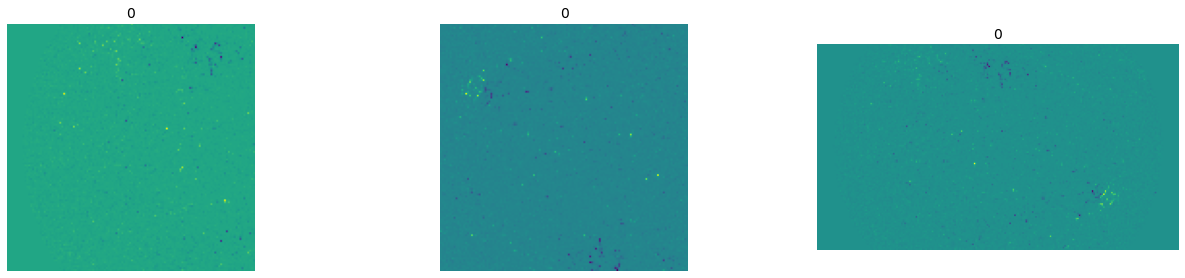

In [8]:
sample_id = 1
img_data_id = 0

samples = [i[0] for i in dm.dataset_train[sample_id][img_data_id]]

plot_image_grid(samples, [0,0,0], columns=3, height=10)

In [ ]:
model = SimCLR(
    num_samples=dm.num_samples,
    batch_size=dm.batch_size,
    dataset='sdo-dataset',
    gpus=2,
    arch="resnet50",
    hidden_mlp = 2048,
    feat_dim = 64,
    n_channel=1,
)

online_finetuner = SSLOnlineEvaluator(
    hidden_dim=128,
    z_dim=model.hidden_mlp,
    num_classes=2,
    learning_rate=1e-5,
    loss_weight=torch.tensor([0.5540, 5.1263], dtype=float)
)

trainer = pl.Trainer(
    max_epochs=100,
    gpus=2,
    accelerator="dp",
    callbacks=[online_finetuner],
    num_sanity_val_steps=0,
    )
trainer.fit(model, datamodule=dm)

### Finetuning

In [3]:
n_channel = 1
n_class = 2
epochs = 5
lr = 1e-4
classes_bin = [
    {"Quiet": "< 1e-6"},
    {">=C": ">= 1e-6"},
]

In [ ]:


datamodule = SDOBenchmarkDataModule(
            Path("../data/sdo-benchmark"),
            batch_size=32,
            validation_size=0.1,
            channel="171",
            resize=128,
            seed=42,
            num_workers=20,
            target_transform=flux_to_class_builder(classes_bin),
            time_steps=3,
        )
datamodule.setup()
datamodule.size()

In [ ]:
total_steps = epochs * len(datamodule.train_dataloader())

model = ImageClassification(
    n_channel=n_channel,
    n_class=n_class,
    learning_rate=lr,
    class_weight = None,
    backbone = "resnet50",
    n_hidden = 512,
    dropout = 0.5,
    lr_scheduler = True,
    lr_scheduler_warmup_steps = 100,
    lr_scheduler_total_steps=total_steps,
)

model.load_pretrained(Path("../models/ssl"), strict=False)

In [ ]:
trainer = pl.Trainer(
        gpus=1,
        max_epochs=epochs,
        num_sanity_val_steps=0,
    )

trainer.fit(model, datamodule=datamodule)

### Loading pre-trained models

In [ ]:
model.load_pretrained("solarnet-ssl-bz")
model = ImageClassification.from_pretrained("solarnet-ssl-bz")